# Описание и импорты

Решение состоит из 5 частей

1. Анализ предоставленных данных и создание дополнительных фичей
2. Предсказание динамики за день (дополнительная фича)
3. Предсказание динамики среднего обращений между неделями (дополнительная фича)
4. Предсказание обращений (целевая фича)
5. Анализ двух вариантов предсказаний и сохранение результатов

Я обучал три модели машинного обучения для предсказания двух фичей и целевой переменной. В основном использовал **Random Forest** и **Gradient Boosting**

## Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

#Machine learning
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Анализ данных, фичаинжиниринг

Посмотрим на данные, подумаем, какие фичи можно использовать, какие добавить, какие закономерности в данных есть

In [2]:
# Указываем nrows=912, так как это последняя строка, где есть данные 

df = pd.read_excel('./data_files/tinkoff/tinkoff_prognosis.xlsx', engine='openpyxl', usecols=[0, 1], nrows=912)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Дата       912 non-null    datetime64[ns]
 1   Обращения  730 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


In [4]:
# Смотрим, сколько значений надо предсказать

df.isna().sum()

Дата           0
Обращения    182
dtype: int64

In [5]:
df.head()

,Дата,Обращения
0,2018-01-01,4177.0
1,2018-01-02,8375.0
2,2018-01-03,13324.0
3,2018-01-04,15566.0
4,2018-01-05,16257.0


In [6]:
# Для удобства перименовываем

df.rename(columns={'Дата': 'date', 'Обращения': 'requests'}, inplace=True)

In [7]:
df['day_of_week'] = df.date.dt.dayofweek

In [8]:
df['day_of_month'] = df.date.dt.day

In [9]:
df['week_of_year'] = df.date.dt.week

<ipython-input-9-696a9ea2d390>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df.date.dt.week


In [10]:
df['month'] = df.date.dt.month

In [11]:
df['year'] = df.date.dt.year

In [12]:
df.head()

,date,requests,day_of_week,day_of_month,week_of_year,month,year
0,2018-01-01,4177.0,0,1,1,1,2018
1,2018-01-02,8375.0,1,2,1,1,2018
2,2018-01-03,13324.0,2,3,1,1,2018
3,2018-01-04,15566.0,3,4,1,1,2018
4,2018-01-05,16257.0,4,5,1,1,2018


Посмотрим на **распределение обращений** по месяцам и сравним одинаковые месяцы в разные годы

<AxesSubplot:xlabel='date'>

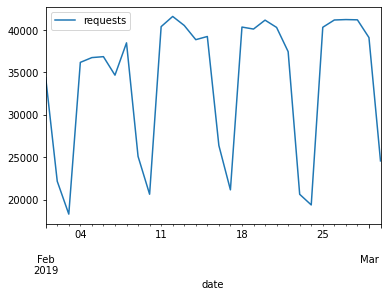

In [13]:
df[396:426].plot(x='date', y='requests')

<AxesSubplot:xlabel='date'>

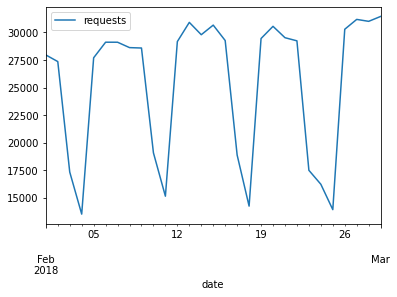

In [14]:
df[31:60].plot(x='date', y='requests')

<AxesSubplot:xlabel='date'>

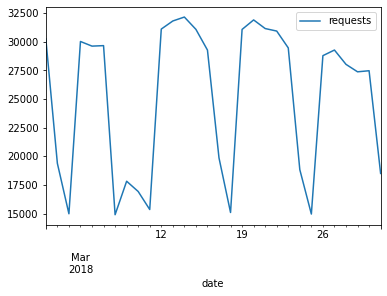

In [15]:
df[60:90].plot(x='date', y='requests')

<AxesSubplot:xlabel='date'>

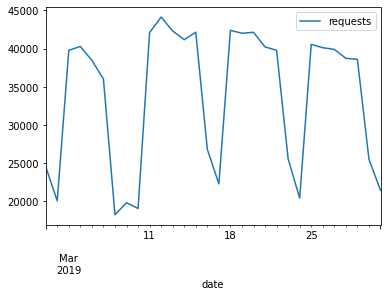

In [16]:
df[425:455].plot(x='date', y='requests')

Можно заметить, что динамика практически **один в один**

In [17]:
# Создаем дф с датами, для которых надо предсказать обращения 

to_predict = df.query('requests.isna()').drop(['date', 'requests'], axis=1)

In [18]:
# Проверяем, что отобрали столько значений, сколько надо предсказать

to_predict.shape

(182, 5)

In [19]:
# Создаем дф с данными, на которых будем обучать модельки

train_data = df.query('~requests.isna()').drop('date', axis=1)

Попробуем показать изменения запросов с помощью переменной (**dynamics**), которая показывает, во сколько раз увеличлось количество запросов по сравнению с предыдущим днем. Самое первое значение будет нулем, потому что первый день не с чем сравнивать

In [20]:
dynamics = [requests_count / train_data.requests[num] for num, requests_count 
            in enumerate(train_data.requests[1:])]

In [21]:
# В первый день динамика ноль

dynamics.insert(0, 0)

In [22]:
train_data['dynamics'] = np.array(dynamics)

Создадим датафреймы с данными за 2018 и 2019 год

In [23]:
train_2018 = train_data[:365]

In [24]:
train_2019 = train_data[365:]

In [25]:
train_data.head()

,requests,day_of_week,day_of_month,week_of_year,month,year,dynamics
0,4177.0,0,1,1,1,2018,0.000000
1,8375.0,1,2,1,1,2018,2.005028
2,13324.0,2,3,1,1,2018,1.590925
3,15566.0,3,4,1,1,2018,1.168268
4,16257.0,4,5,1,1,2018,1.044392


### Посмотрим на изменения динамики в разные меясцы 2018 и 2019 гг.

<AxesSubplot:xlabel='day_of_month'>

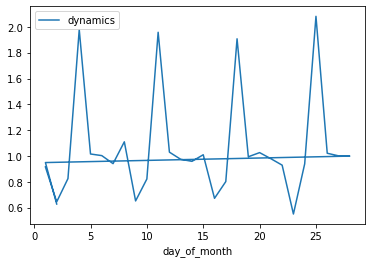

In [26]:
train_data[396:426].plot(x='day_of_month', y='dynamics')

<AxesSubplot:xlabel='day_of_month'>

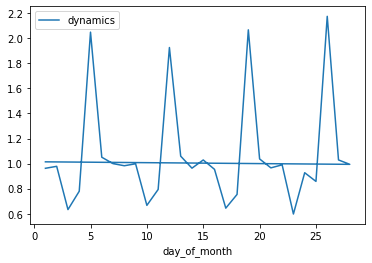

In [27]:
train_data[31:60].plot(x='day_of_month', y='dynamics')

<AxesSubplot:xlabel='day_of_month'>

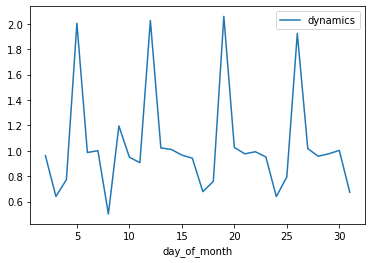

In [28]:
train_data[60:90].plot(x='day_of_month', y='dynamics')

<AxesSubplot:xlabel='day_of_month'>

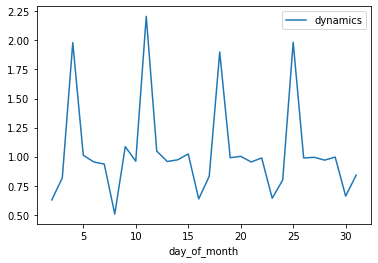

In [29]:
train_data[425:455].plot(x='day_of_month', y='dynamics')

Можно сделать вывод, что каждый месяц динамика примерно одна и та же. Только в 2019 году все сместилось на день назад (если в 2018 пик приходился на 12 число, то в 2019 - на 11)

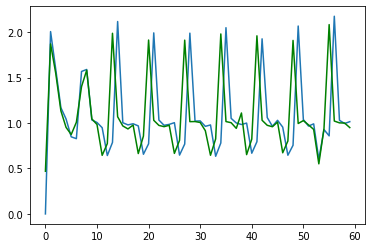

In [30]:
fig, ax = plt.subplots()
ax.plot(range(60), train_2018[:60].dynamics)
ax.plot(range(60), train_2019[:60].dynamics, color='green')

Построили график для первых 60 дней каждого года, динамика **совпадает почти идеально**, только идет смещение на 1 день. Гипотеза подтверждается <br>
P.S. Можно построить графики и на более долгий период, они будут также совпадать, но визуально их воспринимать тяжелее

In [31]:
train_data.sort_values(by='dynamics', ascending=False).head(10).sort_values(by='month')

,requests,day_of_week,day_of_month,week_of_year,month,year,dynamics
14,29857.0,0,15,3,1,2018,2.115567
56,30280.0,0,26,9,2,2018,2.173726
420,40309.0,0,25,9,2,2019,2.081861
434,42091.0,0,11,11,3,2019,2.206721
483,37176.0,0,29,18,4,2019,2.388743
98,27624.0,0,9,15,4,2018,2.349779
91,28204.0,0,2,14,4,2018,2.066530
129,28671.0,3,10,19,5,2018,2.315352
497,41577.0,0,13,20,5,2019,2.135988
490,37678.0,0,6,19,5,2019,2.098118


Судя по всему, наибольшее количество запросов в понедельник (нулевой день недели)

Попробуем построить матрицу корреляций, чтобы подтвердить гипотезу о том, что на количество обращений влияет день недели

<AxesSubplot:>

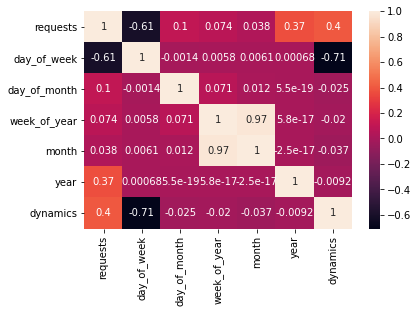

In [32]:
sns.heatmap(train_data.corr(), annot=True)

Корреляция между днем недели и динамикой около 70%

Наложим количество запросов 2018 на количество запросов в 2019 в первые 60 дней

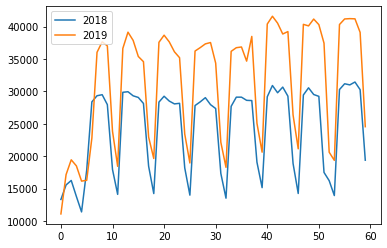

In [33]:
plt.plot(range(60), train_2018.requests[2:62], label='2018')
plt.plot(range(60), train_2019.requests[1:61], label='2019')
plt.legend()

Судя по всему, каждый год среднее количество обращений увеличивается во сколько-то раз. Попробуем посмотреть, во сколько раз увеличилось среднее в 2019 по сравнению с 2018

In [34]:
year_coeff = train_2019.requests.mean() / train_2018.requests.mean()
year_coeff

1.2301557014237434

Посмотрим на динамику среднего обращений за неделю

In [35]:
requests_mean_by_week = train_data.groupby(['year', 'week_of_year']).requests.mean()

<AxesSubplot:xlabel='year,week_of_year'>

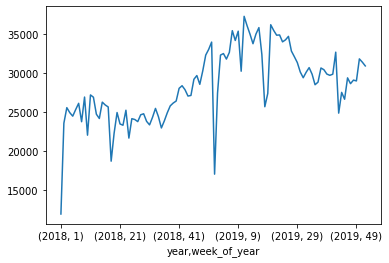

In [36]:
requests_mean_by_week.plot()

In [37]:
requests_mean_by_week = requests_mean_by_week.to_frame() \
                        .rename(columns={'requests': 'mean_requests_by_week'}).reset_index()

In [38]:
requests_mean_by_week.head()

,year,week_of_year,mean_requests_by_week
0,2018,1,11942.500000
1,2018,2,23581.714286
2,2018,3,25572.285714
3,2018,4,24931.142857
4,2018,5,24483.000000


Попробуем посчитать динамику изменений среднего между неделями

In [39]:
mean_requests_dynamics = [mean_requests / requests_mean_by_week.mean_requests_by_week[num] for num, mean_requests 
            in enumerate(requests_mean_by_week.mean_requests_by_week[1:])]

In [40]:
# Первая динамика ноль, потому что это первая неделя

mean_requests_dynamics.insert(0, 0)

In [41]:
requests_mean_by_week['mean_dynamics'] = mean_requests_dynamics

<AxesSubplot:>

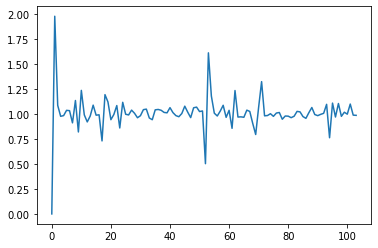

In [42]:
requests_mean_by_week.mean_dynamics.plot()

In [43]:
# train_data = train_data.merge(requests_mean_by_week, on=['year', 'week_of_year'], how='outer')

In [44]:
# train_data.drop(['year'], axis=1, inplace=True)
# to_predict.drop(['year'], axis=1, inplace=True)

# 2. Предсказываем динамику обращений каждый день

Протестируем разные модельки, посмотрим, как они себя ведут

In [45]:
X = train_data.drop(['requests', 'dynamics'], axis=1)
y = train_data.dynamics.values.reshape(-1, 1)

In [46]:
X.head()

,day_of_week,day_of_month,week_of_year,month,year
0,0,1,1,1,2018
1,1,2,1,1,2018
2,2,3,1,1,2018
3,3,4,1,1,2018
4,4,5,1,1,2018


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Тестируем модели для предсказания динамики

### Linear Regression

In [48]:
lin_reg = linear_model.LinearRegression().fit(X_train, y_train)

In [49]:
lin_reg.score(X_train, y_train)

0.5107066256044661

In [50]:
lin_reg.score(X_test, y_test)

0.4630244971874975

**Вывод:** Плохая точность

### Ridge Regression

In [51]:
ridge_reg = linear_model.Ridge()

In [52]:
ridge_params = {'alpha': np.arange(0, 10, 0.1)}

In [53]:
ridge_seacrh = GridSearchCV(ridge_reg, ridge_params, cv=5, n_jobs=-1, verbose=1)

In [54]:
ridge_seacrh.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.5s finished


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             verbose=1)

In [55]:
ridge_seacrh.best_score_

0.49709727377608315

In [56]:
best_ridge = ridge_seacrh.best_estimator_

In [57]:
best_ridge.score(X_test, y_test)

0.4639845390489806

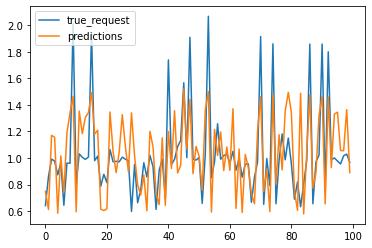

In [58]:
plt.plot(range(100), y_test[:100], label='true_request')
plt.plot(range(100), best_ridge.predict(X_test)[:100], label='predictions')
plt.legend(loc='upper left')

**Вывод:** точность слишком низкая

### Random Forest

In [59]:
rf_reg = ensemble.RandomForestRegressor()

In [60]:
rf_params = {'n_estimators': range(50, 200, 50), 'max_depth': range(1, 6), 
             'min_samples_leaf': range(1, 10, 2), 'min_samples_split': range(2, 10, 2)}

In [61]:
rf_search = GridSearchCV(rf_reg, rf_params, cv=5, n_jobs=-1, verbose=1)

In [62]:
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   52.6s finished
c:\users\owner\pycharmprojects\datascience_stepik\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 10, 2),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(50, 200, 50)},
             verbose=1)

In [63]:
rf_search.best_score_

0.8084472896272181

In [64]:
rf_search.best_params_

{'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [65]:
# best_params_rf = {'max_depth': 3,
#                   'min_samples_leaf': 1,
#                   'min_samples_split': 7,
#                   'n_estimators': 100}

In [66]:
best_rf_reg = rf_search.best_estimator_

In [67]:
# best_rf_reg = ensemble.RandomForestRegressor(**best_params_rf).fit(X_train, y_train)

In [68]:
best_rf_reg.score(X_test, y_test)

0.8439997971643194

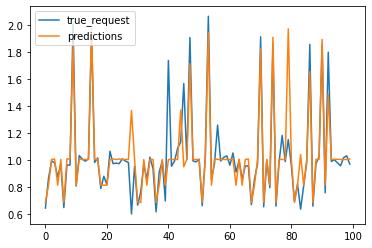

In [69]:
plt.plot(range(100), y_test[:100], label='true_request')
plt.plot(range(100), best_rf_reg.predict(X_test)[:100], label='predictions')
plt.legend(loc='upper left')

In [70]:
pd.DataFrame({'name': list(X), 'importances': best_rf_reg.feature_importances_})

,name,importances
0,day_of_week,0.893008
1,day_of_month,0.017315
2,week_of_year,0.078390
3,month,0.008324
4,year,0.002964


**Вывод:** точность гораздо выше, чем у линейных моделей

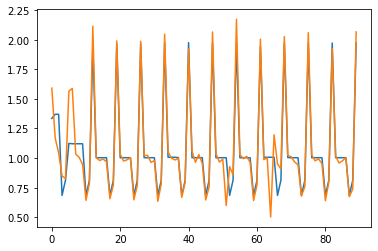

In [71]:
# Предскажем значения для 90 дней 2020 года и сравним с первыми 90 дней 2018 (данные 2018 нужно будет сдвинуть на 2 дня 
# вперед, потому что 2018 начинается с понедельника, а 2020 со среды. Нам важны именно дни недели)

plt.plot(range(90), best_rf_reg.predict(to_predict)[:90])
plt.plot(range(90), train_data.dynamics[2:92])

Максимумы и минимумы совпадают почти идеально

### Gradient Boosting

In [72]:
gb_reg = ensemble.GradientBoostingRegressor()

In [73]:
gb_params = {'learning_rate': np.arange(0, 0.5, 0.05), 'n_estimators': range(50, 200, 50), 
             'max_depth': range(1, 5), 'min_samples_split': range(2, 10, 2)}

In [74]:
gb_search = GridSearchCV(gb_reg, gb_params, cv=5, n_jobs=-1, verbose=1)

In [75]:
gb_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1428 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 2128 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   22.3s finished
c:\users\owner\pycharmprojects\datascience_stepik\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'max_depth': range(1, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(50, 200, 50)},
             verbose=1)

In [76]:
gb_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [77]:
gb_search.best_score_

0.8129284465791408

In [78]:
best_gb = gb_search.best_estimator_

In [79]:
best_gb.score(X_test, y_test)

0.8264996757983414

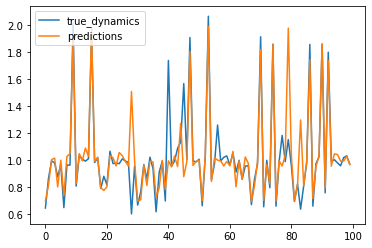

In [80]:
plt.plot(range(100), y_test[:100], label='true_dynamics')
plt.plot(range(100), best_gb.predict(X_test)[:100], label='predictions')
plt.legend(loc='upper left')

In [81]:
pd.DataFrame({'name': list(X_train), 'importances': best_gb.feature_importances_})

,name,importances
0,day_of_week,0.862963
1,day_of_month,0.029743
2,week_of_year,0.095937
3,month,0.004526
4,year,0.006830


**Вывод:** Gradient Boosting показывает очень похожий результат с Random Forest

## Считаем динамику с помощью лучшей модели (Gradient Boosting)


Лучшие результаты показали **Random Forest** и **Gradient Boosting** - точность в райноне 80-85%. Будем использовать Gradient Boosting для предсказания

In [82]:
# Используем лучшие параметры, которые нашел GridSearchCV

best_gb_params = gb_search.best_params_

# best_gb_params = {'learning_rate': 0.11,
#                   'max_depth': 2,
#                   'min_samples_split': 7,
#                   'n_estimators': 50}

In [83]:
gb_reg = ensemble.GradientBoostingRegressor(**best_gb_params).fit(X, y)

c:\users\owner\pycharmprojects\datascience_stepik\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [84]:
gb_reg.score(X, y)

0.8951651393072453

In [85]:
pd.DataFrame({'name': list(X), 'importances': gb_reg.feature_importances_})

,name,importances
0,day_of_week,0.883265
1,day_of_month,0.029310
2,week_of_year,0.076197
3,month,0.004417
4,year,0.006811


Начинаем преобразовывать **dynamics** в обращения. Нужно просто взять количество обращений прошлого дня и умножить на dynamics

In [86]:
predictions_2020 = to_predict.copy()

In [87]:
predictions_2020['dynamics'] = gb_reg.predict(to_predict)

In [88]:
predictions_2020.head()

,day_of_week,day_of_month,week_of_year,month,year,dynamics
730,2,1,1,1,2020,1.098487
731,3,2,1,1,2020,1.671260
732,4,3,1,1,2020,1.340415
733,5,4,1,1,2020,0.803566
734,6,5,1,1,2020,0.899202


In [89]:
# Возьмем количество запросов последнего дня 2019 года. По ним будем считать будущие запросы

last_day_requests = train_data.requests.iloc[-1]

In [90]:
requests =  []

In [91]:
for coeff in predictions_2020.dynamics:
    last_day_requests = last_day_requests * coeff
    requests.append(last_day_requests)

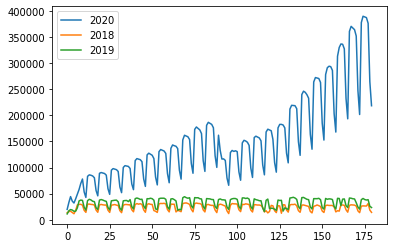

In [92]:
plt.plot(range(180), requests[:180], label='2020')
plt.plot(range(180), train_2018.requests[2:182], label='2018')
plt.plot(range(180), train_2019.requests[1:181], label='2019')
plt.legend()

Посчитаем, во сколько раз увеличилось среднее занчение обращений с 2018 по 2019, потом с 2019 по 2020

In [93]:
# Во столько раз увеличилось с 2018 по 2019

train_2019.requests.mean() / train_2018.requests.mean()

1.2301557014237434

In [94]:
# Во столько раз увеличилось с 2019 по 2020

np.array(requests).mean() / train_2019.requests.mean()

5.064300556014923

С 2019 по 2020 увеличлось слишком сильно

Как оказывается, предсказывать просто динамику, а по ней считать обращения - плохая идея. Каждый год количество обращений увеличиватся не сильно (в 1.23 раза), а наш алгоритм увеличил в 3-6 раз. Будем использовать **динамику** как дополнительную фичу в построении моделей для предсказании обращений

In [95]:
to_predict['dynamics'] = gb_reg.predict(to_predict)

In [96]:
to_predict.head()

,day_of_week,day_of_month,week_of_year,month,year,dynamics
730,2,1,1,1,2020,1.098487
731,3,2,1,1,2020,1.671260
732,4,3,1,1,2020,1.340415
733,5,4,1,1,2020,0.803566
734,6,5,1,1,2020,0.899202


In [97]:
train_data.head()

,requests,day_of_week,day_of_month,week_of_year,month,year,dynamics
0,4177.0,0,1,1,1,2018,0.000000
1,8375.0,1,2,1,1,2018,2.005028
2,13324.0,2,3,1,1,2018,1.590925
3,15566.0,3,4,1,1,2018,1.168268
4,16257.0,4,5,1,1,2018,1.044392


# 3. Предсказываем динамику по средним обращениям за неделю

В качестве еще одной фичи можно использовать динамику по средним обращениям в неделю (то есть насколько среднее на первой недели отличается от среднего на второй и т.д.)

In [98]:
X = train_data.merge(requests_mean_by_week.drop('mean_requests_by_week', axis=1), 
            on=['year', 'week_of_year'])
y = X.mean_dynamics

In [99]:
X = X.drop(['requests', 'mean_dynamics'], axis=1)

In [100]:
X.head()

,day_of_week,day_of_month,week_of_year,month,year,dynamics
0,0,1,1,1,2018,0.000000
1,1,2,1,1,2018,2.005028
2,2,3,1,1,2018,1.590925
3,3,4,1,1,2018,1.168268
4,4,5,1,1,2018,1.044392


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Тестируем модели для предсказания средней динамики

### Random Forest

In [102]:
rf_reg = ensemble.RandomForestRegressor()

In [103]:
rf_params = {'n_estimators': range(50, 200, 50), 'max_depth': range(1, 6), 
             'min_samples_leaf': range(1, 10, 2), 'min_samples_split': range(2, 10, 2)}

In [104]:
rf_search = GridSearchCV(rf_reg, rf_params, cv=5, n_jobs=-1, verbose=1)

In [105]:
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   58.0s finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 10, 2),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(50, 200, 50)},
             verbose=1)

In [106]:
rf_search.best_score_

0.8511224664501367

In [107]:
rf_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [108]:
# best_params_rf = {'max_depth': 3,
#                   'min_samples_leaf': 1,
#                   'min_samples_split': 7,
#                   'n_estimators': 100}

In [109]:
best_rf_reg = rf_search.best_estimator_

In [110]:
# best_rf_reg = ensemble.RandomForestRegressor(**best_params_rf).fit(X_train, y_train)

In [111]:
best_rf_reg.score(X_test, y_test)

0.8256150662351693

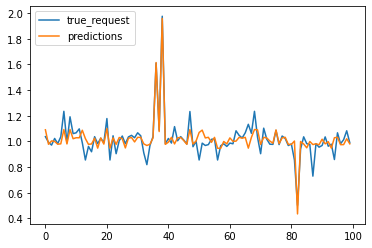

In [112]:
plt.plot(range(100), y_test[:100], label='true_request')
plt.plot(range(100), best_rf_reg.predict(X_test)[:100], label='predictions')
plt.legend(loc='upper left')

In [113]:
pd.DataFrame({'name': list(X), 'importances': best_rf_reg.feature_importances_})

,name,importances
0,day_of_week,0.001823
1,day_of_month,0.054453
2,week_of_year,0.874985
3,month,0.008875
4,year,0.054107
5,dynamics,0.005757


**Вывод:** Точность хорошая

### Gradient Boosting

In [114]:
gb_reg = ensemble.GradientBoostingRegressor()

In [115]:
gb_params = {'learning_rate': np.arange(0, 0.5, 0.05), 'n_estimators': range(50, 200, 50), 
             'max_depth': range(1, 5), 'min_samples_split': range(2, 10, 2)}

In [116]:
gb_search = GridSearchCV(gb_reg, gb_params, cv=5, n_jobs=-1, verbose=1)

In [117]:
gb_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1428 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2128 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   26.2s finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'max_depth': range(1, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(50, 200, 50)},
             verbose=1)

In [118]:
gb_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 4,
 'min_samples_split': 4,
 'n_estimators': 100}

In [119]:
gb_search.best_score_

0.9579648182636854

In [120]:
best_gb = gb_search.best_estimator_

In [121]:
best_gb.score(X_test, y_test)

0.9603457720332459

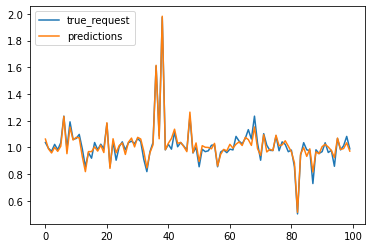

In [122]:
plt.plot(range(100), y_test[:100], label='true_request')
plt.plot(range(100), best_gb.predict(X_test)[:100], label='predictions')
plt.legend(loc='upper left')

In [123]:
pd.DataFrame({'names': list(X), 'importances': best_gb.feature_importances_})

,names,importances
0,day_of_week,0.005458
1,day_of_month,0.049425
2,week_of_year,0.839307
3,month,0.016782
4,year,0.070689
5,dynamics,0.018339


**Gradient Boosting** показывает очень крутой результат

## Предскажем среднюю динамику c помощью лучшей модели (Gardient boosting)

In [124]:
# best_gb_params = {'learning_rate': 0.31000000000000005,
#                   'max_depth': 4,
#                   'min_samples_split': 3,
#                   'n_estimators': 100}

In [125]:
best_gb_params = gb_search.best_params_

In [126]:
gb_reg = ensemble.GradientBoostingRegressor(**best_gb_params).fit(X, y)

In [127]:
gb_reg.score(X, y)

0.9951671845594466

In [128]:
to_predict['mean_dynamics'] = gb_reg.predict(to_predict)

In [129]:
train_data['mean_dynamics'] = y

<AxesSubplot:>

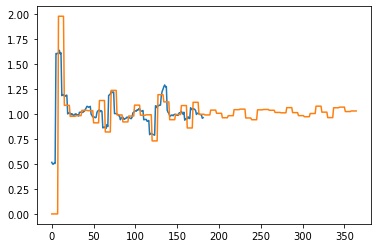

In [130]:
to_predict.reset_index().mean_dynamics.plot()
train_data[:365].reset_index().mean_dynamics.plot()

# 4. Предсказываем обращения (requests)

In [131]:
X = train_data.drop('requests', axis=1)
y = train_data.requests

In [132]:
X.head()

,day_of_week,day_of_month,week_of_year,month,year,dynamics,mean_dynamics
0,0,1,1,1,2018,0.000000,0.0
1,1,2,1,1,2018,2.005028,0.0
2,2,3,1,1,2018,1.590925,0.0
3,3,4,1,1,2018,1.168268,0.0
4,4,5,1,1,2018,1.044392,0.0


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Тренируем модели. Random Forest и Gradient Boosting

### Random Forest

In [134]:
rf_reg = ensemble.RandomForestRegressor()

In [135]:
rf_params = {'n_estimators': range(50, 200, 50), 'max_depth': range(1, 6), 
             'min_samples_leaf': range(1, 10, 2), 'min_samples_split': range(2, 10, 2)}

In [136]:
rf_search = GridSearchCV(rf_reg, rf_params, cv=5, n_jobs=-1, verbose=1)

In [137]:
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 10, 2),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(50, 200, 50)},
             verbose=1)

In [138]:
rf_search.best_score_

0.8620423808321073

In [139]:
rf_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [140]:
# best_params_rf = {'max_depth': 3,
#                   'min_samples_leaf': 1,
#                   'min_samples_split': 7,
#                   'n_estimators': 100}

In [141]:
best_rf_reg = rf_search.best_estimator_

In [142]:
# best_rf_reg = ensemble.RandomForestRegressor(**best_params_rf).fit(X_train, y_train)

In [143]:
best_rf_reg.score(X_test, y_test)

0.9087084676116135

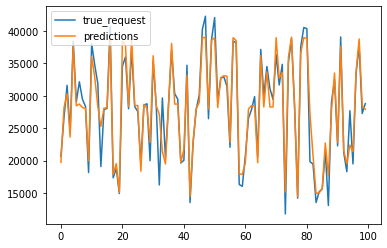

In [144]:
plt.plot(range(100), y_test[:100], label='true_request')
plt.plot(range(100), best_rf_reg.predict(X_test)[:100], label='predictions')
plt.legend(loc='upper left')

### Gradient Boosting

In [145]:
gb_reg = ensemble.GradientBoostingRegressor()

In [146]:
gb_params = {'learning_rate': np.arange(0, 0.5, 0.05), 'n_estimators': range(50, 200, 50), 
             'max_depth': range(1, 5), 'min_samples_split': range(2, 10, 2)}

In [147]:
gb_search = GridSearchCV(gb_reg, gb_params, cv=5, n_jobs=-1, verbose=1)

In [148]:
gb_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1428 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2128 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   29.2s finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'max_depth': range(1, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(50, 200, 50)},
             verbose=1)

In [149]:
gb_search.best_params_

{'learning_rate': 0.25,
 'max_depth': 4,
 'min_samples_split': 6,
 'n_estimators': 150}

In [150]:
gb_search.best_score_

0.9180742974074843

In [151]:
best_gb = gb_search.best_estimator_

In [152]:
best_gb.score(X_test, y_test)

0.9214039923035416

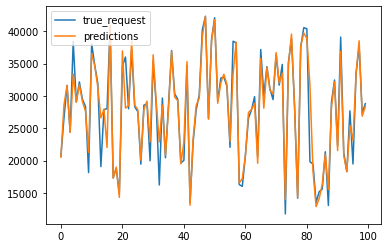

In [153]:
plt.plot(range(100), y_test[:100], label='true_request')
plt.plot(range(100), best_gb.predict(X_test)[:100], label='predictions')
plt.legend(loc='upper left')

**Gradient Boosting** показывает очень хороший результат

In [154]:
pd.DataFrame({'names': list(X), 'importances': best_gb.feature_importances_})

,names,importances
0,day_of_week,0.053333
1,day_of_month,0.017585
2,week_of_year,0.086815
3,month,0.023807
4,year,0.150691
5,dynamics,0.597863
6,mean_dynamics,0.069906


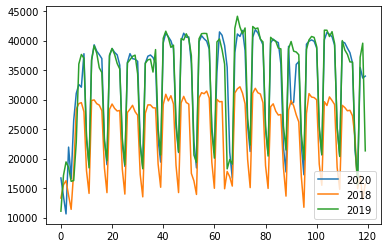

In [155]:
plt.plot(range(120), best_gb.predict(to_predict)[:120], label='2020')
plt.plot(range(120), train_2018.requests[2:122], label='2018')
plt.plot(range(120), train_2019.requests[1:121], label='2019')
plt.legend()

Остается главная проблема - среднее количество обращений в 2020 **не выросло** по сравненинию с 2019. Попробуем это исправить вручную на следующем этапе

## Предсказываем обращения с помощью Gradient Boosting

In [156]:
best_gb_params = gb_search.best_params_

In [157]:
gb_reg = ensemble.GradientBoostingRegressor(**best_gb_params).fit(X, y)

In [158]:
gb_reg.score(X, y)

0.9992313989739093

Чтобы решить проблему, домножим на **коэффициент**, насколько в среднем увеличилось количество обращений в 2019 году по сравнению с 2018

In [159]:
year_coeff

1.2301557014237434

In [175]:
predcit_requests = gb_reg.predict(to_predict) * year_coeff

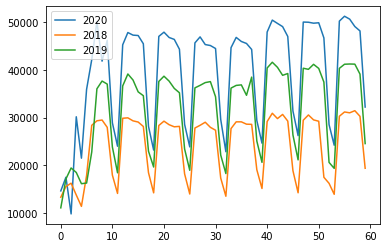

In [162]:
plt.plot(range(60), predcit_requests[:60], label='2020')
plt.plot(range(60), train_2018.requests[2:62], label='2018')
plt.plot(range(60), train_2019.requests[1:61], label='2019')
plt.legend()

# 5. Сравнение предсказаний и сохранение

В результате у нас есть два варианта предсказаний: обычное и домноженное на коэффециент года

In [194]:
to_predict_common = to_predict.copy() 

In [195]:
to_predict_common['requests'] = gb_reg.predict(to_predict)

In [196]:
to_predicrt_coeff = to_predict.copy()

In [197]:
to_predicrt_coeff['requests'] = gb_reg.predict(to_predict) * year_coeff

### Обычное

<AxesSubplot:>

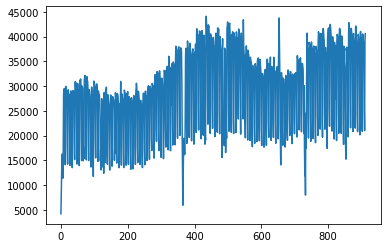

In [198]:
df.requests.fillna(to_predict_common.requests).plot()

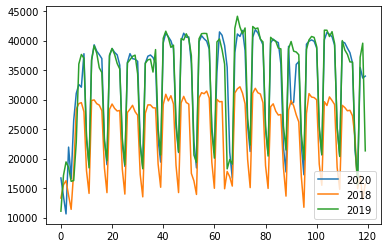

In [199]:
plt.plot(range(120), best_gb.predict(to_predict)[:120], label='2020')
plt.plot(range(120), train_2018.requests[2:122], label='2018')
plt.plot(range(120), train_2019.requests[1:121], label='2019')
plt.legend()

### Домноженное на коэффициент

<AxesSubplot:>

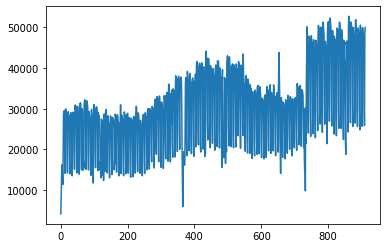

In [200]:
df.requests.fillna(to_predicrt_coeff.requests).plot()

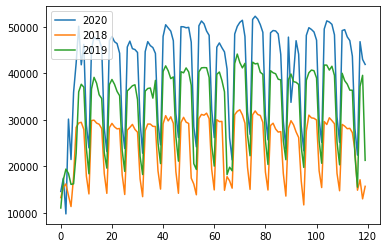

In [184]:
plt.plot(range(120), predcit_requests[:120], label='2020')
plt.plot(range(120), train_2018.requests[2:122], label='2018')
plt.plot(range(120), train_2019.requests[1:121], label='2019')
plt.legend()

**Вывод:** Несмотря на то, что интуитивно в 2020 году среднее количесво обращений должно быть больше, чем в 2019 (то есть вариант с домножением на коэффициент года), общий график с 2018 по 2020 выглядит неествественно. Гораздо естественнее выглядит вариант без домножения на коэффициент. Его и оставим

### Сохранение

In [203]:
data_with_predcitions = df[['date', 'requests']].fillna(to_predict_common)

<AxesSubplot:xlabel='date'>

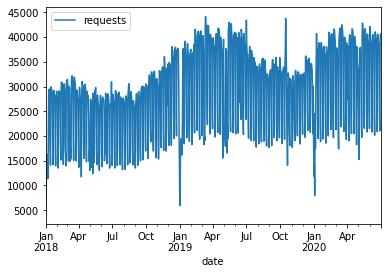

In [206]:
data_with_predcitions.plot(x='date', y='requests')

In [207]:
data_with_predcitions.to_excel('./data_files/tinkoff/task1_with_predictions.xlsx')